## Quantum Computing - Final project

### Solving satisfiability problems using Grover’s Algorithm

Trabalho realizado por:

- Bruno Miguel Ferreira Fernandes, A95972
- Carlos André Machado Costa, A94543


###  Design a solvable 3-SAT boolean formula.

Na primeira tarefa deste trabalho prático, é solicitada a criação de uma fórmula booleana 3-SAT. Uma fórmula booleana 3-SAT é uma fórmula que pode ser satisfeita ou não, como o próprio nome indica. Isso significa que se houver uma atribuição de valores de verdade para as variáveis que a torne verdadeira, então ela é satisfeita. Caso contrário, não é. Além disso, cada cláusula de uma fórmula 3-SAT deve conter 3 variáveis.

      Assim sendo, consideremos a seguinte fórmula,f: 

   f(v1,v2,v3) = ( ¬v1 ∨ ¬v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ v3) ∧ (v1 ∨ v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ ¬v3) ∧ ( ¬v1 ∨ v2 ∨ v3)

Consideremos:

    x1 = ( ¬v1 ∨ ¬v2 ∨ ¬v3)
    
    x2 = (  v1 ∨ ¬v2 ∨  v3)
    
    x3 = (  v1 ∨  v2 ∨ ¬v3)
    
    x4 = (  v1 ∨ ¬v2 ∨ ¬v3)
    
    x5 = ( ¬v1 ∨  v2 ∨  v3)
    

| v1 | v2 | v3 | x1 | x2 | x3 | x4 | x5 | f  |
|----|----|----|----|----|----|----|----|----|
| 0  | 0  | 0  | 1  | 1  | 1  | 1  | 1  | 1  |
| 0  | 0  | 1  | 1  | 1  | 0  | 1  | 1  | 0  |
| 0  | 1  | 0  | 1  | 0  | 1  | 1  | 1  | 0  |
| 0  | 1  | 1  | 1  | 1  | 1  | 0  | 1  | 0  |
| 1  | 0  | 0  | 1  | 1  | 1  | 1  | 0  | 0  |
| 1  | 0  | 1  | 1  | 1  | 1  | 1  | 1  | 1  |
| 1  | 1  | 0  | 1  | 1  | 1  | 1  | 1  | 1  |
| 1  | 1  | 1  | 0  | 1  | 1  | 1  | 1  | 0  |


Com base nos dados coletados da tabela lógica resultante, podemos concluir que, estamos diante de uma fórmula booleana 3-SAT solúvel, conforme pretendíamos.

### Implementaçao do Algoritmo De Grover

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import MCXGate,ZGate
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

O Algoritmo de Grover é composto por três etapas: inicialização, o Oráculo e o Difusor.

Para implementá-lo corretamente, é necessário saber quantos qubits serão necessários. Levando em consideração que precisamos de um qubit para cada variável inicial, um qubit para o resultado final e um qubit para cada cláusula presente na fórmula, podemos concluir que serão necessários 11 qubits.

- Construção do circuito.

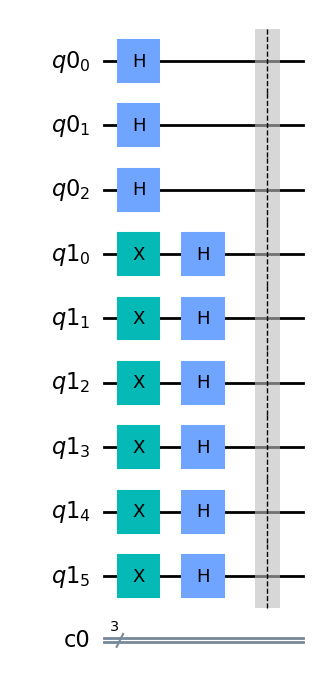

In [3]:
#Criação do Circuito
n_qubits = 9
qr = QuantumRegister(3)
ancilla = QuantumRegister(6)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr, ancilla)

# Sobreposição uniforme
qc.h(qr)

# |-> inicializar
qc.x(ancilla)
qc.h(ancilla)

qc.barrier()

qc.draw(output="mpl")


## Óraculo


In [4]:
def oracle(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    # f1
    qc.mcx(qr,ancilla[0])
    qc.x(ancilla[0])
    
    #f2
    qc.x(qr[0])
    qc.x(qr[2])
    qc.mcx(qr,ancilla[1])
    qc.x(ancilla[1])
    qc.x(qr[0])
    qc.x(qr[2])
    
    #f3
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr,ancilla[2])
    qc.x(ancilla[2])
    qc.x(qr[0])
    qc.x(qr[1])
    
    #f4
    qc.x(qr[0])
    qc.mcx(qr,ancilla[3])
    qc.x(ancilla[3])
    qc.x(qr[0])
    
    
    #f5
    qc.x(qr[1])
    qc.x(qr[2])
    qc.mcx(qr,ancilla[4])
    qc.x(ancilla[4])
    qc.x(qr[1])
    qc.x(qr[2])
    
    #F
    qc.mcx(ancilla[:-1],ancilla[-1])
    qc.x(ancilla[-1])
        

    qc.barrier()
    return qc

## Difusor

O operador de difusão age sobre os 3 qubits que representam os literais, seguindo o seguinte procedimento:

1. Aplica uma porta Hadamard aos 3 qubits para remover o estado de sobreposição.
2. Aplica um porta $X$ aos 3 qubits.
3. Aplica uma porta Toffoli de múltiplo controle aos dois primeiros qubits e ao terceiro.
4. Aplica uma porta Hadamard aos 3 qubits.


In [5]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])

    qc.mcx(qr[:-1],qr[-1])
    
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()
    
    return qc 

### Qual o número de iterações necessárias ?

In [6]:
elementos = 2**3
iteracoes= int(np.floor(np.pi/4 * np.sqrt(elementos/3)))
print("Numero de iterações necessárias: %d " % iteracoes)

Numero de iterações necessárias: 1 


### Composição do circuito com oráculo e difusor

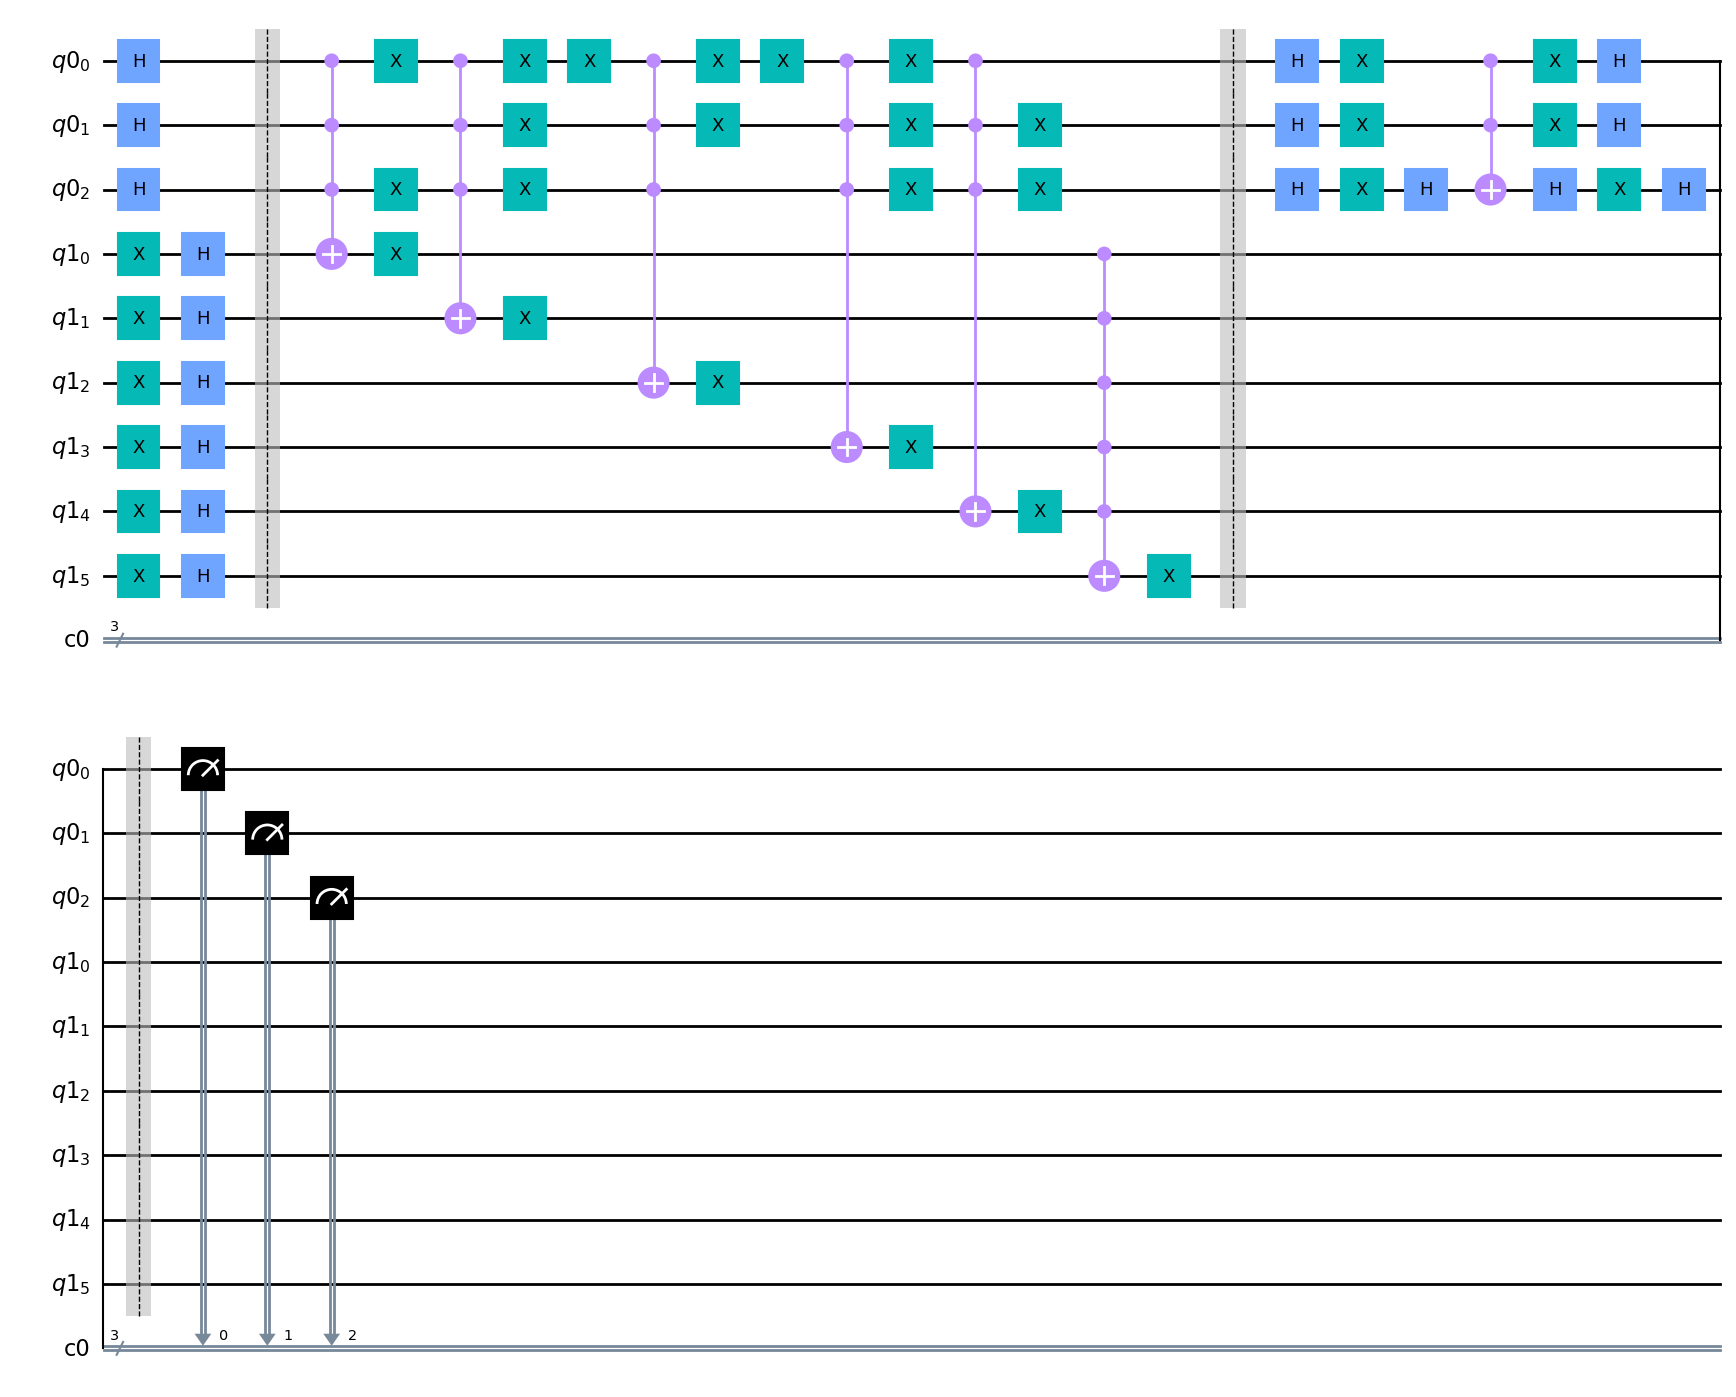

In [7]:
for i in range(iteracoes):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))

qc.measure(qr,cr)
qc.draw(output="mpl")

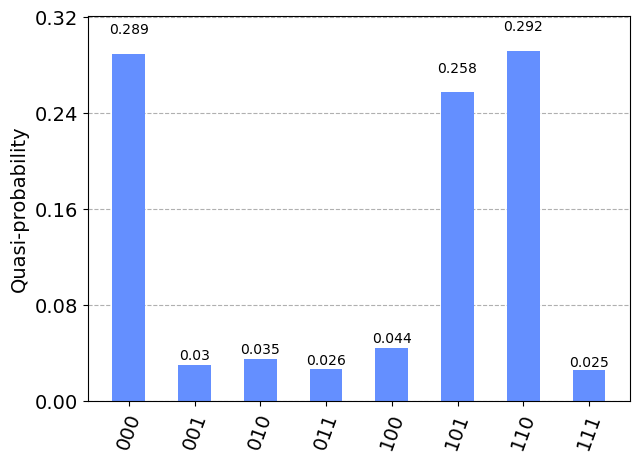

In [8]:
counts = execute_circuit(qc, reversed=True)
plot_distribution(counts)

### Testes para 2 e 3 iterações para comparação de resultados

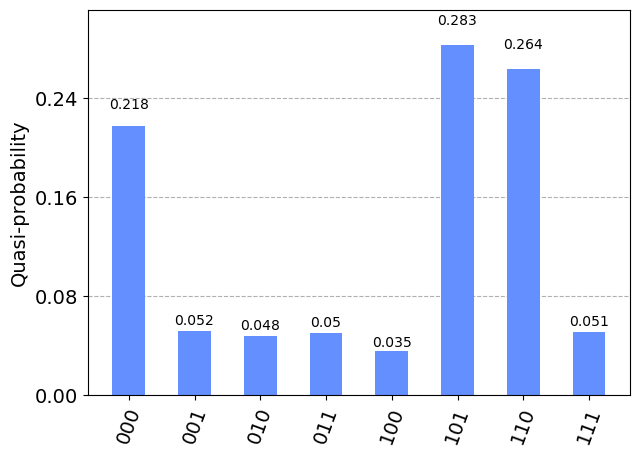

In [9]:
for j in range(2):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))


qc.measure(qr,cr)
qc.draw(output="mpl")

counts = execute_circuit(qc,reversed=True)
plot_distribution(counts)

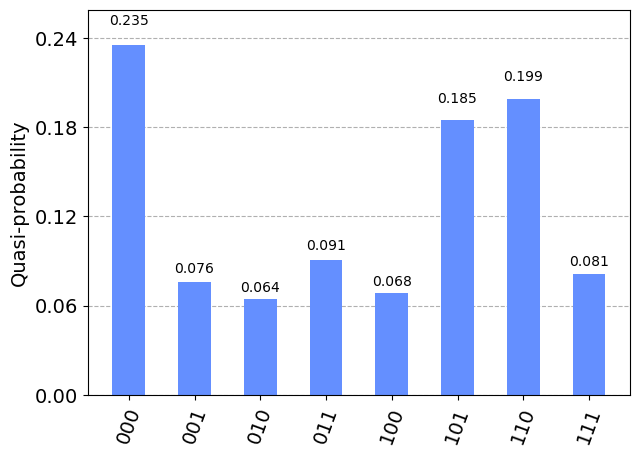

In [10]:
for j in range(3):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))


qc.measure(qr,cr)
qc.draw(output="mpl")

counts = execute_circuit(qc,reversed=True)
plot_distribution(counts)

## Conclusão

Em síntese, a realização deste projeto revelou-se altamente proveitosa, não apenas por nos permitir consolidar de forma mais efetiva os tópicos abordados em sala de aula, mas também por possibilitar a aplicação desses conhecimentos num contexto de trabalho. Ademais, acreditamos ter alcançado plenamente os objetivos propostos.